In [1]:
import numpy as np #导入numpy库
import matplotlib.pyplot as plt #导入matplotlib库
from mpl_toolkits.mplot3d import Axes3D #导入3D坐标轴支持
from scipy.linalg import solve  # 导入 solve 函数
from scipy.linalg import eigh, svd, qr  # 导入函数
from scipy.sparse import eye, csr_matrix, find  # 导入函数
from scipy.sparse.linalg import eigsh  # 导入函数
from itertools import product

In [2]:
# 计算成对距离的函数（使用向量化操作）
def pairwise_distances(X):
    dist_matrix = np.sqrt(np.sum((X[:, None] - X) ** 2, axis=2))
    return dist_matrix

# 计算最近邻的索引（使用向量化操作和argsort函数一次性找到最近邻索引）
def nearest_neighbors(X, k):
    dist_matrix = pairwise_distances(X)
    return dist_matrix.argsort(axis=1)[:, 1:k+1]

# 计算权重矩阵的函数（使用向量化操作）
def barycenter_weights(X, Z, reg=1e-3):
    n_samples, n_neighbors = X.shape[0], Z.shape[1]
    B = np.empty((n_samples, n_neighbors), dtype=X.dtype)
    v = np.ones(n_neighbors, dtype=X.dtype)

    for i, A in enumerate(Z.transpose(0, 2, 1)):
        C = A.T - X[i]
        G = np.dot(C, C.T)
        trace = np.trace(G)
        R = reg * trace if trace > 0 else reg
        G.flat[::Z.shape[1] + 1] += R

        w = solve(G, v)
        B[i, :] = w / np.sum(w)

    return B

# 计算邻居的索引（避免重复计算）
def get_neighbors_indices(X, n_neighbors):
    n_samples = X.shape[0]
    knn_indices = np.zeros((n_samples, n_neighbors), dtype=int)

    def find_indices(i):
        knn_indices[i] = nearest_neighbors(X, n_neighbors)[i]

    for i in range(n_samples):
        find_indices(i)

    return knn_indices

# 计算权重矩阵的函数
def barycenter_kneighbors(X, n_neighbors, reg=1e-3):
    n_samples = X.shape[0]
    ind = get_neighbors_indices(X, n_neighbors)
    data = barycenter_weights(X, X[ind], reg=reg)
    indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
    return csr_matrix((data.ravel(), ind.ravel(), indptr),
                      shape=(n_samples, n_samples))

# 低维嵌入算法实现
def Embed(Weight_Matrix, n_components):
    # 计算矩阵 M
    I = np.identity(Weight_Matrix.shape[1])
    M = (I - Weight_Matrix).T @ (I - Weight_Matrix)
    # 计算矩阵M的特征值及特征向量
    eigenvalues, eigenvectors = np.linalg.eigh(M)
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    return selected_eigenvectors

def LLE(data, n_neighbors, n_components):
    # 计算权重矩阵
    Weight_Matrix = barycenter_kneighbors(data, n_neighbors)  # 计算权重矩阵
    # 计算降维后的结果
    embeddings = Embed(Weight_Matrix, n_components)  # 计算降维后的嵌入结果
    return embeddings  # 返回嵌入结果

Text(0.5, 1.0, 'Spiral Dataset')

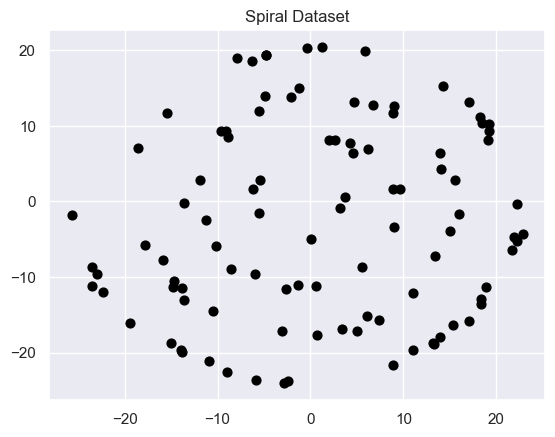

In [3]:
import seaborn as sns
sns.set()  # 设置 seaborn 默认格式

# 加载保存的数据集
data = np.loadtxt('./spiral_dataset.csv', delimiter=',')
# 将第一列数据分配给 x，第二列数据分配给 y
x = data[:, 0]
y = data[:, 1]

# 绘制散点图
plt.figure()
plt.scatter(x, y, c='black', s=40)  # 绘制散点图，用黑色表示数据点，设置点的大小为 40
plt.title('Spiral Dataset')  # 设置图标题为 'Spiral Dataset'


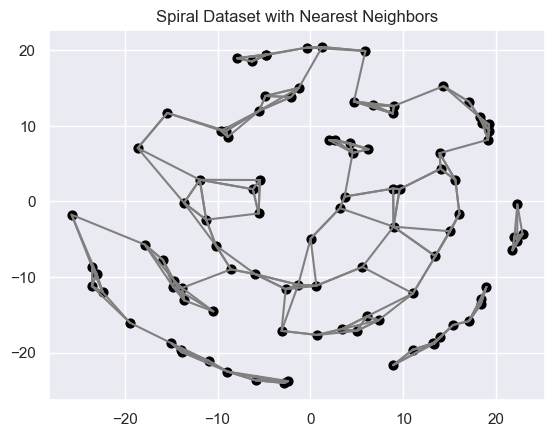

In [4]:
# 遍历每个数据点并绘制到最近邻的连线
plt.figure()
plt.scatter(data[:,0], data[:,1], alpha=1, c='black', s=40)  # 绘制散点图，alpha 为不透明度，用黑色表示数据点，点的大小为 40
n_neighbors = 3  # 设置最近邻的数量为 3
neighbors = nearest_neighbors(data, n_neighbors).astype('int')  # 找到每个数据点的最近邻索引，返回整数数组

# 循环遍历每个数据点
for i in range(len(data)):
    knn = neighbors[i]  # 获取第 i 个数据点的最近邻索引
    # 循环遍历每个最近邻
    for j in range(n_neighbors):
        # 绘制连接当前点与其最近邻之间的灰色线段
        plt.plot(data[[i, knn[j]], 0], data[[i, knn[j]], 1], c='gray')  # 绘制当前点与最近邻之间的连线，颜色为灰色
plt.title('Spiral Dataset with Nearest Neighbors');

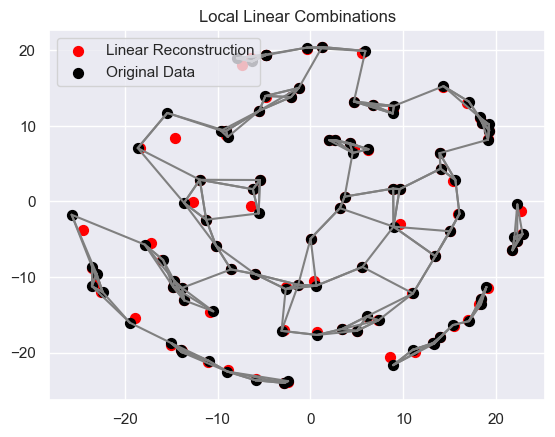

In [5]:
# 利用 barycenter_kneighbors 函数计算权重矩阵 W
W = barycenter_kneighbors(data, n_neighbors)  # 使用函数计算权重矩阵

linear_combos = []  # 初始化存储线性组合结果的列表
neighborhood_weights = []  # 初始化存储邻域权重的列表

# 循环遍历每个数据点
for i in range(len(data)):
    weights = W.toarray()[i][neighbors[i]]  # 获取当前点的权重
    neighborhood = data[neighbors[i]]  # 获取当前点的邻域数据点
    weighted_neighbors = weights.reshape(-1, 1) * neighborhood  # 计算加权邻域点
    lin_x1 = np.sum(weighted_neighbors[:, 0])  # 计算线性组合后的 x1 坐标
    lin_x2 = np.sum(weighted_neighbors[:, 1])  # 计算线性组合后的 x2 坐标
    linear_combos.append([lin_x1, lin_x2])  # 将线性组合的结果添加到列表中
    neighborhood_weights.append(weights)  # 将邻域权重添加到列表中
linear_X = np.array(linear_combos)  # 将线性组合的结果转换为 NumPy 数组

# 绘制散点图，用红色表示线性重构的数据点，用黑色表示原始数据点
plt.figure()

# 循环遍历每个数据点
for i in range(len(data)):
    knn = neighbors[i]  # 获取第 i 个数据点的最近邻索引
    # 循环遍历每个最近邻
    for j in range(n_neighbors):
        # 绘制连接当前点与其最近邻之间的灰色线段
        plt.plot(data[[i, knn[j]], 0], data[[i, knn[j]], 1], c='gray')  # 绘制当前点与最近邻之间的连线，颜色为灰色

plt.scatter(linear_X[:, 0], linear_X[:, 1], c='red', s=50, label='Linear Reconstruction')
plt.scatter(data[:, 0], data[:, 1], c='black', s=50, label='Original Data')
plt.title('Local Linear Combinations')  # 设置图标题为 'Local Linear Combinations'
plt.legend(loc='upper left');  # 设置图例位置在左上角

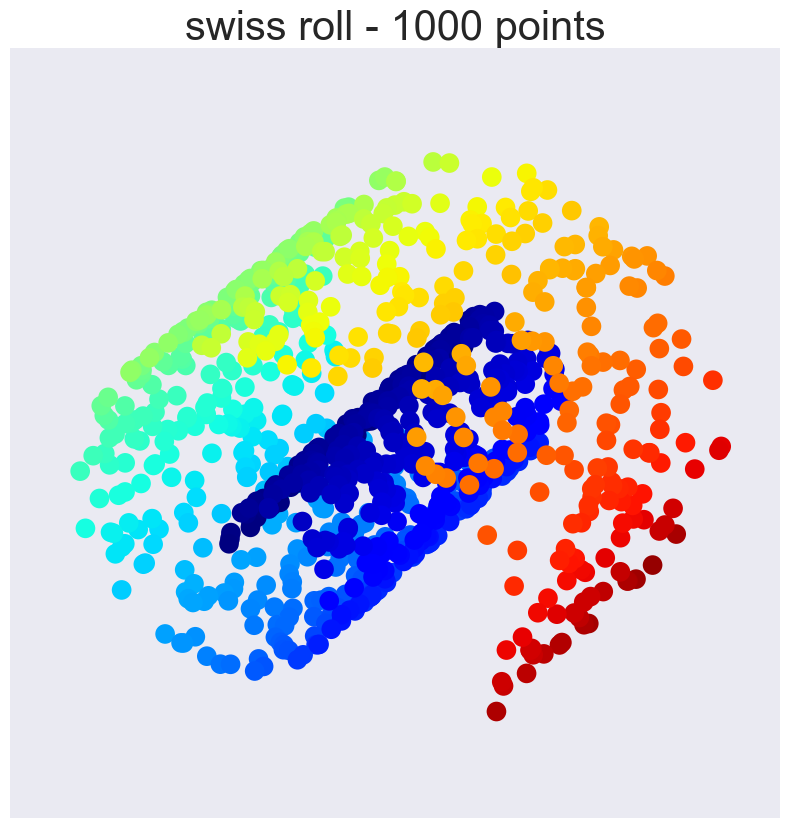

In [6]:
# 生成数据集
'''
n = 100
x = np.random.rand(2, n)
v = 3 * np.pi / 2 * (.1 + 2 * x[0, :])
X = np.zeros([3, n])
X[1, :] = 20 * x[1, :]
X[0, :] = -np.cos(v) * v
X[2, :] = np.sin(v) * v
'''
swiss=np.load('./swiss roll-1000.npy')
swiss_trans = np.transpose(swiss)
# k为swiss数据集的样本点个数
k=swiss.shape[1]
# 绘制 swiss roll 数据集
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(swiss[0, :], swiss[1, :], swiss[2, :], c=plt.cm.jet((swiss[0, :]**2 + swiss[2, :]**2) / 100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(swiss[0, :]), np.max(swiss[0, :]))
ax.set_ylim(np.min(swiss[1, :]), np.max(swiss[1, :]))
ax.set_zlim(np.min(swiss[2, :]), np.max(swiss[2, :]))
plt.title('swiss roll - '+ str(k) + ' points', size=30)
ax.axis("off");

In [7]:
n_components=2
n_neighbors=70

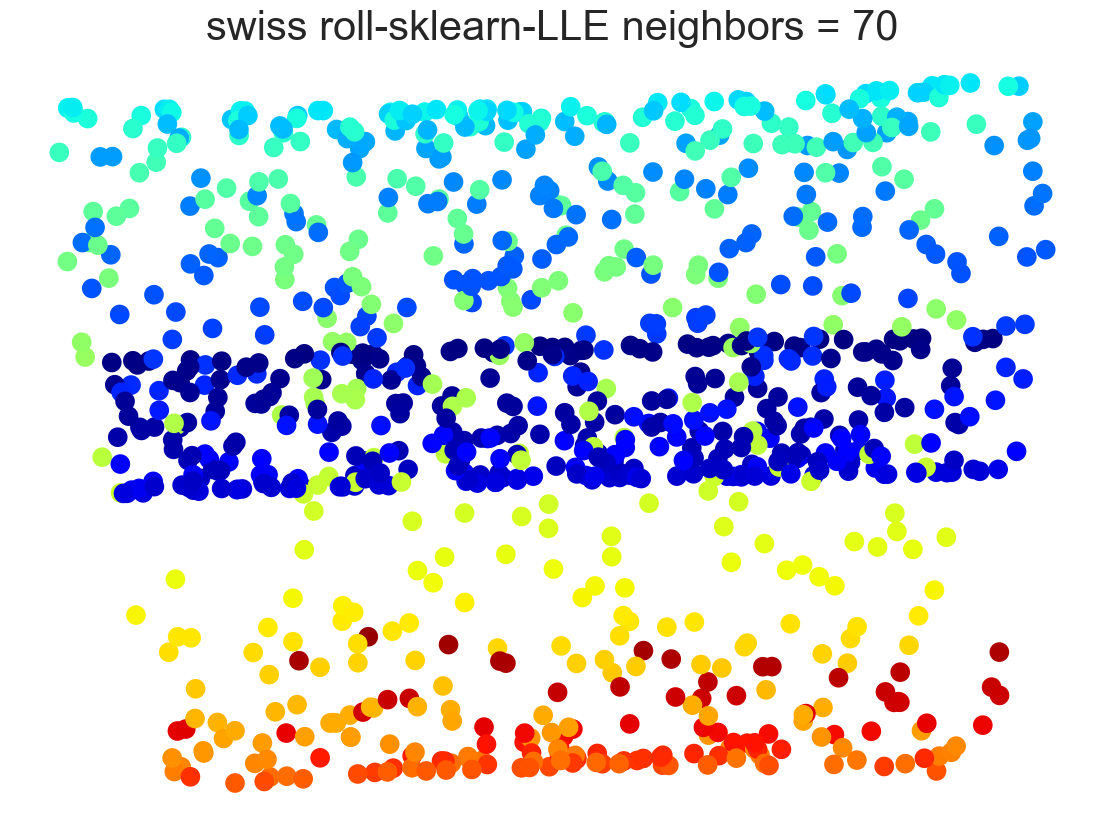

In [8]:
# 使用 sklearn 库中的 LocallyLinearEmbedding 函数降维
from sklearn.manifold import LocallyLinearEmbedding
# 创建 LocallyLinearEmbedding 实例
lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors) 
# 对数据集进行降维处理
X_reduced = lle.fit_transform(swiss_trans)
# 绘制 Isomap 投影图
plt.figure(figsize=(14,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=plt.cm.jet((swiss_trans[:,0]**2+swiss_trans[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('swiss roll-sklearn-LLE neighbors = ' + str(n_neighbors), size=30)
plt.axis("off");

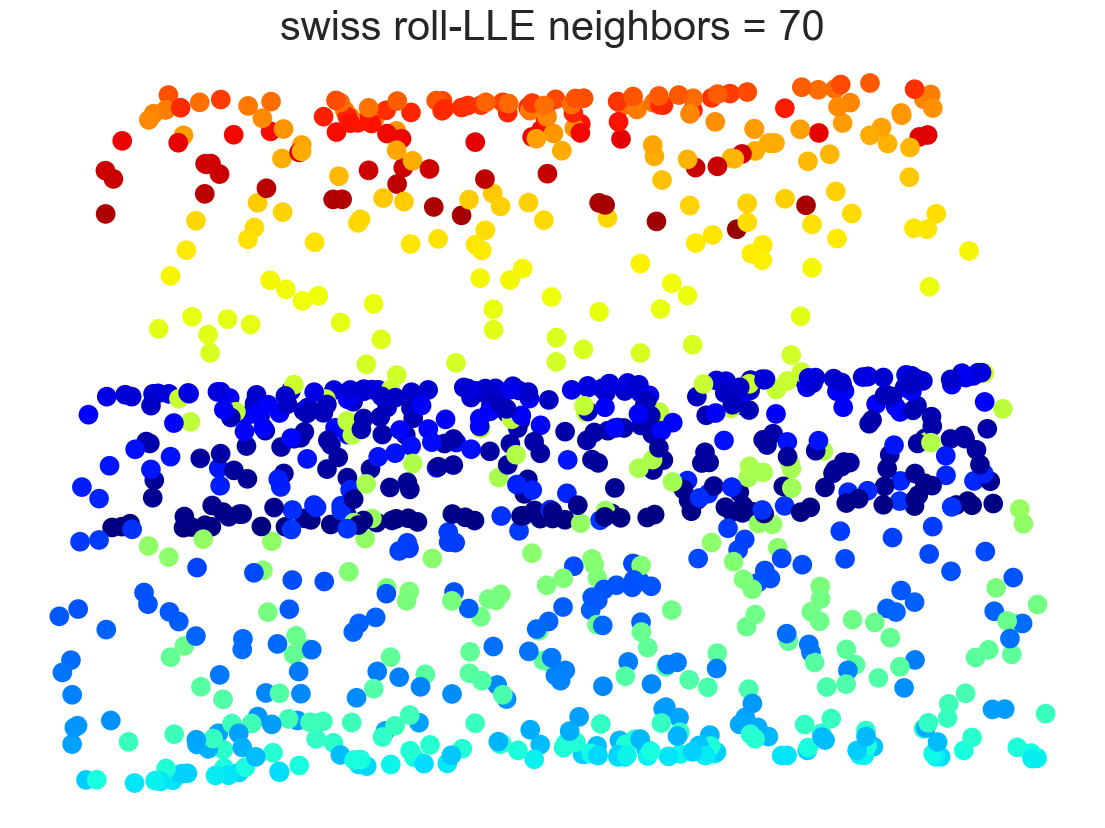

In [9]:
# 使用 LLE 算法降维
LLE_X = LLE(swiss_trans, n_neighbors, n_components)  # 使用 LLE 算法降维，将数据维度从 3D 减少到 2D
# 绘制 Isomap 投影图
plt.figure(figsize=(14,10))
plt.scatter(LLE_X[:, 0].tolist(), LLE_X[:, 1].tolist(), c=plt.cm.jet((swiss_trans[:,0]**2+swiss_trans[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('swiss roll-LLE neighbors = ' + str(n_neighbors), size=30)
plt.axis("off");